# Fluxonium-transmon system as a function of external flux

We study a system of capacitively coupled transmon and fluxonium as a function of the external magnetic flux in the fluxonium. Specifically, we want to analyze how the energy of the higher transitions behave as a function of the external flux in the fluxonium to check if we can use this property to selectively activate the gate between different pairs of qubits following a scheme similar to Ficheux et al. Phys. Rev. X 11, 021026 (2021)  

In [178]:
import numpy as np
import time
import qutip as qtp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pysqkit
from pysqkit.util.quantum import generalized_rabi_frequency
import pysqkit.util.transformations as trf
from pysqkit.util.hsbasis import weyl_by_index
from pysqkit import QubitSystem
from typing import List, Dict, Callable
from matplotlib.ticker import FormatStrFormatter
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'

from IPython.display import display, Latex

In what follows we will mainly analyze how the energy levels of the fluxonium vary as a function of the external flux, but we will also ficticiously introduce a transmon at a certain frequency to see if we can activate the gate. The Hamiltonian of the capacitively coupled system is

$$H = H^{(0)}_T + H^{(0)}_F + V ,$$

$$H^{(0)}_T =  \hbar \omega_T \hat{b}^{\dagger}\hat{b} + \hbar \frac{\delta_T}{2} \hat{b}^{\dagger} \hat{b}^{\dagger}\hat{b} \hat{b},$$

$$H^{(0)}_F = 4 E_{C,F} \cdot \hat{q}^2_F + \frac{1}{2}E_{L,F}\cdot\hat{\varphi}^2_F - E_{J,F}\cos\left(\hat{\varphi}_F - \phi_{ext,F}\right),$$

$$V = J_C \cdot \hat{q}_T \cdot \hat{q}_F.$$

The (approximate) charge operator for the transmon in terms of annihilation and creation operators reads

$$
\hat{q}_T = i \biggl( \frac{E_J}{32 |\delta_T |} \biggr)^{1/4} (b^{\dagger} - b),
$$
where 
$$
E_J = \hbar \biggl(\frac{\omega_T - \delta_T}{8 | \delta_T |} \biggr)^2.
$$

# Introducing the qubits

In [179]:
#Fluxonium
levels_f = 7

# Basic fluxonium from previous analysis
flx = pysqkit.qubits.Fluxonium(
    label='F', 
    charge_energy=.973, 
    induct_energy=.457, 
    joseph_energy=8.0
)
flx.diagonalize_basis(levels_f)

We will mostly be interested in how the fluxonium energies vary as a function of its parameters. First of all I will study how the eigenenergies of the fluxonium vary as a function of $E_L$ for $3$ values of $E_J$. 

In [180]:
ej_list = [6.0, 8.0, 10.0]
n_points = 100
el_list = np.linspace(0.2, 1.0, n_points)

In [181]:
energies = {}
for ej in ej_list:
    list_en = []
    for el in el_list:
        flx_tmp = pysqkit.qubits.Fluxonium(
            label='F_tmp',
            charge_energy=.973,
            induct_energy=el,
            joseph_energy=ej        
        )
        flx_tmp.diagonalize_basis(levels_f)
        groundenergy = flx_tmp.state('0')[0]
        en_flx = flx_tmp.eig_energies() - groundenergy
        list_en.append(en_flx)
    energies[str(ej)] = list_en

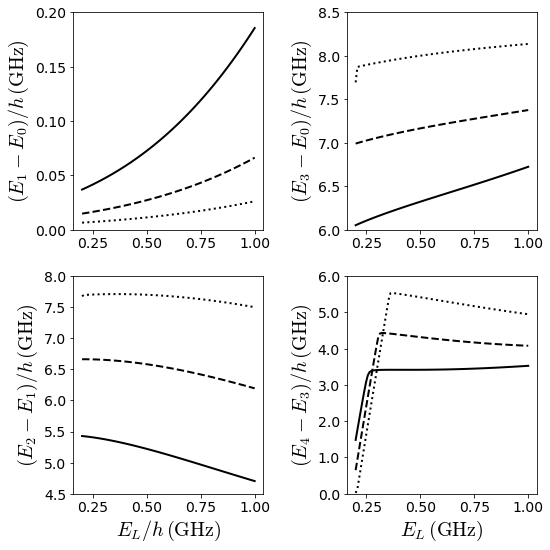

In [182]:
def plot_relevant_frequencies(
    el_list: list,
    energies: dict, 
    opt: dict
):
    fig, ax = plt.subplots(2, 2, figsize=(8, 8))
    n_points = len(el_list)
    n_lev = len(energies['6.0'][0])
    ej_list = list(energies.keys())
    style_list = ['-', '--', ':']
    for ej_str, style in zip(ej_list, style_list):
        omega_01 = []
        omega_03 = []
        omega_12 = []
        omega_34 = []
        for index in range(n_points):
            omega_01.append(energies[ej_str][index][1])
            omega_03.append(energies[ej_str][index][3])
            omega_12.append(energies[ej_str][index][2] - energies[ej_str][index][1])
            omega_34.append(energies[ej_str][index][4] - energies[ej_str][index][3])
        ax[0, 0].plot(el_list, omega_01, linestyle=style, linewidth=opt["lw"], color='black')
        ax[0, 1].plot(el_list, omega_03, linestyle=style, linewidth=opt["lw"], color='black')
        ax[1, 0].plot(el_list, omega_12, linestyle=style, linewidth=opt["lw"], color='black')
        ax[1, 1].plot(el_list, omega_34, linestyle=style, linewidth=opt["lw"], color='black')
    ax[1, 0].axes.set_xlabel('$E_L/h \, (\mathrm{GHz})$', fontsize=opt['fs'])
    ax[1, 1].axes.set_xlabel('$E_L \, (\mathrm{GHz})$', fontsize=opt['fs'])
    ax[0, 0].axes.set_ylabel('$(E_1 - E_0)/h \, (\mathrm{GHz})$', fontsize=opt['fs'])
    ax[0, 1].axes.set_ylabel('$(E_3 - E_0)/h \, (\mathrm{GHz})$', fontsize=opt['fs'])
    ax[1, 0].axes.set_ylabel('$(E_2 - E_1)/h \, (\mathrm{GHz})$', fontsize=opt['fs'])
    ax[1, 1].axes.set_ylabel('$(E_4 - E_3)/h \, (\mathrm{GHz})$', fontsize=opt['fs'])
    ax[0, 0].tick_params(axis='both', labelsize=opt['ls'])
    ax[0, 1].tick_params(axis='both', labelsize=opt['ls'])
    ax[1, 0].tick_params(axis='both', labelsize=opt['ls'])
    ax[1, 1].tick_params(axis='both', labelsize=opt['ls'])
    ax[0, 0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax[0, 0].set_ylim(0, 0.2)
    ax[0, 1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax[0, 1].set_ylim(6.0, 8.5)
    ax[1, 0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax[1, 0].set_ylim(4.5, 8.0)
    ax[1, 1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax[1, 1].set_ylim(0.0, 6.0)
    fig.tight_layout(pad=2.0)
    plt.show()

plot_setup = {'lw': 2.0, 'fs': 20, 'fs_text': 14, 'ls': 14}
plot_relevant_frequencies(el_list, energies, plot_setup)

where the solid, dashed, dotted line correspond to $E_J = 6.0, \, 8.0, \, 10.0 \, (\mathrm{GHz})$ respectively. The plot shows how by increasing $E_J$ we can reach a regime where the transition $3-4$ is characterized by a frequency close to the typical transmon frequencies, while the transitions $1-2$ and $0-3$ are still far away and thus we expect small $ZZ$ coupling coming from these transitions when we couple capacitively a transmon. To further confirm this we now couple a transmon capacitively to a fluxonium with a fixed $E_L$ and we plot the $ZZ$ coupling for different $E_J$. Specifically we will look at the following two quantities


$$\zeta_{ZZ} = E_{00} + E_{11} - E_{01} - E_{10}$$
$$\Delta = \left( E_{13} - E_{10} \right) -  \left( E_{03} - E_{00} \right)$$,

the $\Delta$ parameter sets the gate speed of the gate.

In [183]:
def zz(system: QubitSystem) -> float:
    xi_zz = system.state('00')[0] + system.state('11')[0] \
        - system.state('01')[0] - system.state('10')[0]
    return xi_zz

def delta(system: QubitSystem) -> float:
    delta_gate = (system.state('13')[0] - system.state('10')[0]) - \
        (system.state('03')[0] - system.state('00')[0])
    return delta_gate 

Previously we set the transmon frequency to be about $150 \, \mathrm{MHz}$  above the $3-4$ transition of the fluxonium. In the folllowing we will consider the case in which we put the transmon above or below the $3-4$ transition by $150 \, \mathrm{MHz}$, and plot the $ZZ$ coupling and $\Delta$

In [202]:
ej_list2 = list(np.linspace(6.0, 10.0, n_points))
zz_above = np.zeros([n_points])
delta_above = np.zeros([n_points])
omega_above = np.zeros([n_points])
zz_below = np.zeros([n_points])
delta_below = np.zeros([n_points])
omega_below = np.zeros([n_points])
jc = 0.07

start = time.time()

for ej, k in zip(ej_list2, range(n_points)):
    flx_tmp = pysqkit.qubits.Fluxonium(
        label='F', 
        charge_energy=.973, 
        induct_energy=.457, 
        joseph_energy=ej_list2[k]
    )
    flx_tmp.diagonalize_basis(levels_f)
    levels_t = 3
    omega_34 = flx_tmp.state('4')[0] - flx_tmp.state('3')[0]
    omega_above[k] = omega_34 + 0.3
    transm_above = pysqkit.qubits.SimpleTransmon(
        label='T', 
        max_freq=omega_above[k], 
        anharm=-0.3,    
        dim_hilbert=levels_t
    )
    omega_below[k] = omega_34 - 0.3
    transm_below = pysqkit.qubits.SimpleTransmon(
        label='T', 
        max_freq=omega_below[k], 
        anharm=-0.3,    
        dim_hilbert=levels_t
    )
    coupled_sys_above = transm_above.couple_to(flx_tmp, coupling=pysqkit.couplers.capacitive_coupling, 
                                               strength=jc)
    coupled_sys_below = transm_below.couple_to(flx_tmp, coupling=pysqkit.couplers.capacitive_coupling, 
                                               strength=jc)
    zz_above[k] = zz(coupled_sys_above)
    zz_below[k] = zz(coupled_sys_below)
    delta_above[k] = delta(coupled_sys_above)
    delta_below[k] = delta(coupled_sys_below)

end = time.time()

print("Computation time = {} s".format(end - start))
    

Computation time = 63.80226492881775 s


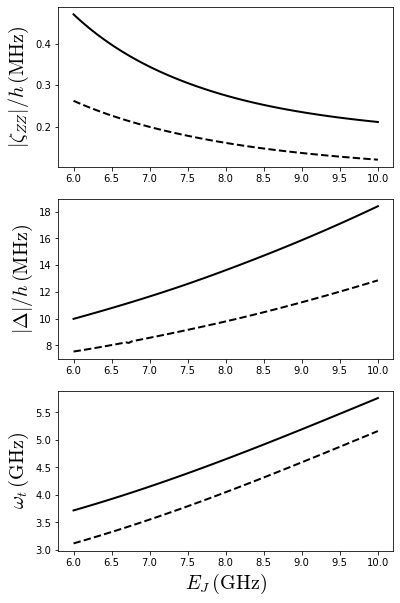

In [203]:
def plot_zz_delta_scan(
    ej: list,
    zz_above: np.ndarray,
    zz_below: np.ndarray,
    delta_above: np.ndarray,
    delta_below: np.ndarray,
    omega_above: np.ndarray,
    omega_below: np.ndarray,
    opt: dict
):
    fig, ax = plt.subplots(3, figsize=(6, 10))
    #colors = ["blue", "red"]
    ax[0].plot(ej, np.abs(zz_above)*1e3, linewidth=opt["lw"], color="black", label="Above")
    ax[0].plot(ej, np.abs(zz_below)*1e3, linewidth=opt["lw"], color="black", linestyle="--", label="Below")
    ax[1].plot(ej, np.abs(delta_above)*1e3, linewidth=opt["lw"], color="black", label="Above")
    ax[1].plot(ej, np.abs(delta_below)*1e3, linewidth=opt["lw"], color="black", linestyle="--", label="Below")
    ax[2].plot(ej, omega_above, linewidth=opt["lw"], color="black", label="Above")
    ax[2].plot(ej, omega_below, linewidth=opt["lw"], color="black", linestyle="--", label="Below")
    ax[2].axes.set_xlabel('$E_J \, (\mathrm{GHz})$', fontsize=opt['fs'])
    ax[0].axes.set_ylabel('$|\zeta_{ZZ}|/h \, (\mathrm{MHz})$', fontsize=opt['fs'])
    ax[1].axes.set_ylabel('$|\Delta|/h \, (\mathrm{MHz})$', fontsize=opt['fs'])
    ax[2].axes.set_ylabel('$\omega_t \, (\mathrm{GHz})$', fontsize=opt['fs'])
    plt.show()

plot_zz_delta_scan(ej_list2, zz_above, zz_below, delta_above, delta_below, 
                   omega_above, omega_below, plot_setup)

The previous plot tells us that it seems advantageous to work with high $E_J$. This is because the $\Delta$ is increasing while the $ZZ$ coupling decreasing in both above and below configuration. In addition, there seems to be no problem in having the fluxonium coupled to two transmons, one above and one below the frequency of $3-4$, so that they can have sufficient separation. However, this obviously relies on the fact that we can target the frequencies with sufficient precision.

In the following I will explore how the spectrum of the fluxonium varies with the external flux. However, this would open up the $1/f$ noise channel